In [1]:
# Along-fjord Momentum Balance terms
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
import gsw

In [15]:
Qsg = 700
hs = 18
File1 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf' + str(format(Qsg,'03d')) + '/state_' + str(format(hs,'03d')) + '.nc')
File2 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf' + str(format(Qsg,'03d')) + '/kpp_state_' + str(format(hs,'03d')) + '.nc')
T0 = 81
Tn = len(File1.T)
State1 = File1.isel(X=range(120), Xp1=range(121), Y=range(30,39), Yp1=range(30,40), T=range(T0,Tn))
State2 = File2.isel(X=range(120), Y=range(30,39), T=range(T0-1,Tn-1))

# U (T,Z,Y,Xp1) W(T,Zl,Y,X) KPPviscAz(T-1,Z,Y,X)
U0 = State1.U.data.mean(axis=(0,2))
#U1 = np.ma.masked_where(U==0, U)
#U0[U0 == 0] = 'nan'
u = (U0[:, 1:] + U0[:, :-1]) / 2

W0 = State1.W.data.mean(axis=(0,2))
#W1 = np.ma.masked_where(W0==0, W0)
#W0[W0 == 0] = 'nan'
Wbt = np.zeros((1,W0.shape[1])) # Add vertical velocity (0 m/s) at the bottom
W = np.concatenate((W0, Wbt), axis=0)
w = (W[1:, :] + W[:-1, :]) / 2
#W = np.concatenate((W0, Wbt), axis=0)
Av = State2.KPPviscAz.data.mean(axis=(0,2)) # Vetical eddy viscosity (m^2/s)
s = State1.S.data.mean(axis=(0,2)) # Salinity
x = State1.X.data
z = State1.Z.data

pt = State1.Temp.data.mean(axis=(0,2)) # Potential temperature
pres = gsw.p_from_z(z, 0) 
p = np.tile(pres,[len(x),1]).T
#rho = gsw.rho(s, pt, p)



#file2.KPPviscAz
#X, Z = np.meshgrid(x, z)
mask = (s == 0) # Exclude data covered by the sill
s[mask] = np.nan
pt[mask] = np.nan
p[mask] = np.nan
#w[mask] = np.nan

uma = np.ma.masked_array(u,mask)
#wma = np.ma.masked_array(w,mask)
#sma = np.ma.masked_array(s,mask)
Avma = np.ma.masked_array(Av,mask)
Av[mask] = np.nan
#State2.KPPviscAz
#pma = np.ma.masked_array(p,mask)
#tma = np.ma.masked_array(pt,mask)
rho = gsw.rho(s, pt, p)

u[mask] = np.nan
w[mask] = np.nan
#u[-1,:], w[-1,:]
u[20,:]

array([        nan,  0.00504046,  0.0088049 ,  0.00444   , -0.00270101,
       -0.01001766, -0.01601515, -0.02039422, -0.02259482, -0.02366666,
       -0.02502804, -0.02661938, -0.02787681, -0.0285457 , -0.02865235,
       -0.02842245, -0.02803798, -0.02765685, -0.02726806, -0.02670056,
       -0.02587832, -0.02485615, -0.02368654, -0.02240901, -0.02103576,
       -0.01955031, -0.01796456, -0.01633901, -0.01474759, -0.01324611,
       -0.01188903, -0.01071142, -0.00969869, -0.00879049, -0.00787517,
       -0.00684033, -0.00563837, -0.00427646, -0.00277058, -0.00112641,
        0.00065993,  0.00259627,  0.00468542,  0.00691677,  0.00924894,
        0.01158831,  0.01377977,  0.01564246,  0.01697779,  0.01763692,
        0.01739391,  0.01581223,  0.01279703,  0.00971329,  0.00748729,
        0.0058961 ,  0.0053734 ,  0.00623706,  0.00470072,  0.01229432,
        0.029429  ,  0.02948993, -0.00300681, -0.0580493 , -0.11960233,
       -0.17989354, -0.24498457, -0.31249028, -0.3412817 , -0.33

In [3]:
# Calculate gradient considering the masked values (NaN)
def masked_gradient(Var, X, Z):
    #Var_x = np.full([Var.shape[0], Var.shape[1]], np.nan)
    #Var_z = np.full([Var.shape[0], Var.shape[1]], np.nan)
    Var_x = Var.copy()
    Var_z = Var.copy()

    for i in range(len(Z)):
        if np.array(np.where(np.isnan(Var[i,1:]))).size == 0: # Var[:,0]=NaN for our output
            #xn1[j] = u.shape[1]
            #xn2[j] = u.shape[1]
            Var_x[i,1:] = np.gradient(Var[i,1:],X[1:])
        else:
            xn1 = np.where(np.isnan(Var[i,:]))[-1][1] # Left boundary of the mask
            xn2 = np.where(np.isnan(Var[i,:]))[-1][-1] + 1 # Right boundary of the mask
            Var_x[i,1:xn1] = np.gradient(Var[i,1:xn1], X[1:xn1])
            Var_x[i,xn2:] = np.gradient(Var[i,xn2:], X[xn2:])
    
    for j in range(len(X)-1): # Exclude Var[:,0]
        if np.array(np.where(np.isnan(Var[:,j+1]))).size == 0:
            Var_z[:,j+1] = np.gradient(Var[:,j+1], Z)        
        else:
            zn = np.where(np.isnan(Var[:,j+1]))[-1][0] # Upper boundary of the mask
            Var_z[:zn,j+1] = np.gradient(Var[:zn,j+1], Z[:zn])
            
    return (Var_x, Var_z)
#L = np.where(np.isnan(us))[-1][0]
#xn1[23], xn2[23], u[23,:66]
#np.where(np.isnan(u[22,1:]))


In [4]:
def Layer(U, X, Z):
    H1 = np.empty(len(X)-2)
    depth = Z
    for i in range(1,len(X)-1):
        l = np.where(U[:, i] < 0)[-1][0] - 1
        #z_th[i-1] =  w[l, i] * pt[l, i]
        #h1[i-1] = -depth[l]
        # Calculate layer depth
        if l <= 9:
            H1[i-1] = -depth[l]+0.25
        elif l <= 19:
            H1[i-1] = -depth[l]+0.5
        elif l <= 29:
            H1[i-1] = -depth[l]+0.75
        elif l <= 39:
            H1[i-1] = -depth[l]+2
        elif l <= 49:
            H1[i-1] = -depth[l]+4
    
    return (H1)

In [5]:
u_x, u_z = masked_gradient(u, x, z)

uma[:,71], u_z[:,71], np.gradient(u[:,71],z)
#np.full((3, 5), np.nan)

(masked_array(data=[0.21732550859451294, 0.21578457951545715,
                    0.21544671058654785, 0.21703322231769562,
                    0.2197338193655014, 0.2225162535905838,
                    0.22489318251609802, 0.22647792100906372,
                    0.227712020277977, 0.22792471945285797,
                    0.22946599125862122, 0.23173949122428894,
                    0.21912400424480438, 0.15351635217666626,
                    0.07677757740020752, -0.009093414060771465,
                    -0.10022519528865814, -0.18767912685871124,
                    -0.25120264291763306, -0.2771502733230591,
                    -0.28576475381851196, -0.2502228021621704, --, --, --,
                    --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                    --, --, --, --, --, --, --, --, --, --, --],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False, False, False, False, False,
           

In [6]:
h1 = Layer(u, x, z)

## Along-fjord velocity gradients
#ux = np.gradient(uma, x, axis=1)
#uz = np.gradient(uma, z, axis=0)
ux, uz = masked_gradient(u, x, z)

# Advective terms
Adv_h = u * ux
Adv_v = w * uz
# Viscous term
#Visc = np.gradient(Avma*uz, z, axis=0) #(Az*Uz)z
K = Av * uz
Azx, Visc = masked_gradient(K, x, z) #(Az*Uz)z
g = 9.8
rhox, rhoz = masked_gradient(rho, x, z)
Ri = -(g/rho)*rhoz / (uz**2)

#Adv_h[mask] = np.nan
#Adv_v[mask] = np.nan
#Visc[mask] = np.nan

range1 = np.array([np.nanmax(Adv_h), np.nanmin(Adv_h), np.nanmean(Adv_h)])
range2 = np.array([np.nanmax(Adv_v), np.nanmin(Adv_v), np.nanmean(Adv_v)])
range3 = np.array([np.nanmax(Visc), np.nanmin(Visc), np.nanmean(Visc)])

#ux[:,71], uz[:,71]
u_z = np.gradient(uma, z, axis=0)
V = np.gradient(Avma*u_z, z, axis=0)
#Av[:,62], Visc[:,62], uz[:,62]
#range1, range2, range3


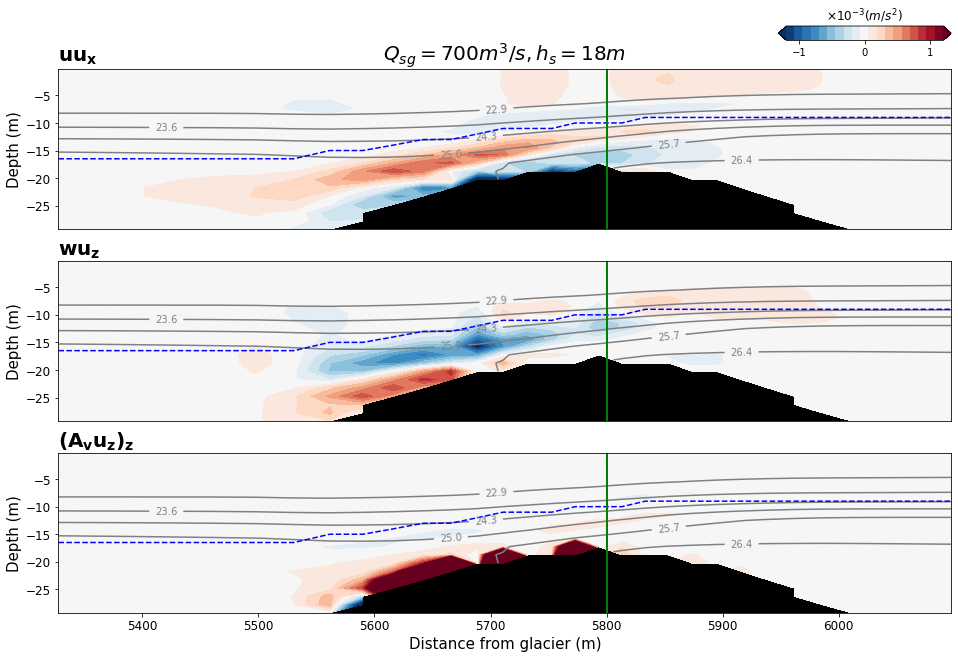

In [7]:
fig1 = plt.figure(figsize=(16,10))
fig1.tight_layout()

cm = np.linspace(-1.2,1.2,20) # Contour range for momentum terms
cs = np.linspace(20,30,15)
cmap = 'RdBu_r'

Xl, Xr = 55, 85 # X range
Zu, Zl = 0, 30 # Z range

# Horizontal Advective Term Plot
ax1 = fig1.add_subplot(311)
im1 = ax1.contourf(x[Xl:Xr], z[Zu:Zl], Adv_h[Zu:Zl,Xl:Xr]*1e3, cm, cmap=cmap, extend='both')
ax1.plot(x[Xl:Xr],-h1[Xl:Xr], '--b')
ax1.xaxis.set_visible(False)
ax1.set_xlim([x[Xl], x[Xr-1]])
ax1.set_facecolor('k')

cbaxes = fig1.add_axes([0.75, 0.92, 0.15, 0.02])
cbar = fig1.colorbar(im1,cax=cbaxes, orientation='horizontal')
cbar.set_ticks([-2, -1, 0, 1, 2])
cbar.ax.set_title(r'$\times10^{-3}(m/s^2)$', size=12, weight='bold')
# Plot isohalines
CS1 = ax1.contour(x[Xl:Xr], z[Zu:Zl], s[Zu:Zl,Xl:Xr], cs, colors = 'grey')
plt.clabel(CS1, fmt='%1.1f', fontsize=10, inline=1)
ax1.axvline(x=5800, color='g',lw=2)
#ax1.axhline(y=-11.5, color='r',lw=2)
ax1.set_ylabel('Depth (m)', size=15)
ax1.tick_params(labelsize=12)
ax1.set_title(r'$\mathbf{uu_x}$', loc='left', size=20)
ax1.set_title(r'$Q_{sg}=$'+str(Qsg)+r'$m^3/s,h_s=$'+str(hs)+'$m$', loc='center', size=20)



# Vertical Advective Term Plot
ax2 = fig1.add_subplot(312)
im2 = ax2.contourf(x[Xl:Xr], z[Zu:Zl], Adv_v[Zu:Zl,Xl:Xr]*1e3, cm, cmap=cmap, extend='both')
ax2.plot(x[Xl:Xr],-h1[Xl:Xr], '--b')
ax2.xaxis.set_visible(False)
ax2.set_xlim([x[Xl], x[Xr-1]])
ax2.set_facecolor('k')
# Plot isohalines
CS2 = ax2.contour(x[Xl:Xr], z[Zu:Zl], s[Zu:Zl,Xl:Xr], cs, colors = 'grey')
plt.clabel(CS2, fmt='%1.1f', fontsize=10, inline=1)
ax2.axvline(x=5800, color='g',lw=2)
ax2.set_ylabel('Depth (m)', size=15)
ax2.tick_params(labelsize=12)
ax2.set_title(r'$\mathbf{wu_z}$', loc='left', size=20)



# qf-tide Plot
ax3 = fig1.add_subplot(313)
im3 = ax3.contourf(x[Xl:Xr], z[Zu:Zl], Visc[Zu:Zl,Xl:Xr]*1e3, cm, cmap=cmap, extend='both')
ax3.plot(x[Xl:Xr],-h1[Xl:Xr], '--b')
ax3.set_xlim([x[Xl], x[Xr-1]])
ax3.set_facecolor('k')
# Plot isohalines
CS3 = ax3.contour(x[Xl:Xr], z[Zu:Zl], s[Zu:Zl,Xl:Xr], cs, colors = 'grey')
plt.clabel(CS3, fmt='%1.1f', fontsize=10, inline=1)
ax3.axvline(x=5800, color='g',lw=2)
ax3.set_ylabel('Depth (m)', size=15)
ax3.tick_params(labelsize=12)
ax3.set_title(r'$\mathbf{(A_v{u_z})_z}$', loc='left', size=20)
ax3.set_xlabel('Distance from glacier (m)', size=15)
ax3.tick_params(labelsize=12)

In [8]:
x[58], x[72], z[9], z[11], z[12], z[14], z[20]

(5460.662111632968, 5813.326713404185, -4.75, -6.5, -7.5, -9.5, -15.75)

In [9]:
def AF_Momentum(Qsg, hs):
    
    file1 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf' + str(format(Qsg,'03d')) + '/state_' + str(format(hs,'03d')) + '.nc')
    file2 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf' + str(format(Qsg,'03d')) + '/kpp_state_' + str(format(hs,'03d')) + '.nc')
    t0 = 81
    tn = len(file1.T)
    state1 = file1.isel(X=range(120), Xp1=range(121), Y=range(30,39), Yp1=range(30,40), T=range(t0,tn))
    state2 = file2.isel(X=range(120), Y=range(30,39), T=range(t0-1,tn-1))

    # U (T,Z,Y,Xp1) W(T,Zl,Y,X) KPPviscAz(T-1,Z,Y,X)
    U = state1.U.data.mean(axis=(0,2))
    u = (U[:, 1:] + U[:, :-1]) / 2
    W0 = state1.W.data.mean(axis=(0,2))
    Wbt = np.zeros((1,W0.shape[1])) # Add vertical velocity (0 m/s) at the bottom
    W = np.concatenate((W0, Wbt), axis=0)
    w = (W[1:, :] + W[:-1, :]) / 2
    #W = np.concatenate((W0, Wbt), axis=0)
    Av = state2.KPPviscAz.data.mean(axis=(0,2)) # Vetical eddy viscosity (m^2/s)
    s = state1.S.data.mean(axis=(0,2)) # Salinity
    x = state1.X.data
    z = state1.Z.data
    #file2.KPPviscAz
    #X, Z = np.meshgrid(x, z)
    mask = (s == 0) # Exclude data covered by the sill
    s[mask] = np.nan
    w[mask] = np.nan
    u[mask] = np.nan
    Av[mask] = np.nan
    #uma = np.ma.masked_array(u,mask)
    #wma = np.ma.masked_array(w,mask)
    #sma = np.ma.masked_array(s,mask)
    #Avma = np.ma.masked_array(Av,mask)
    
    # Along-fjord velocity gradients
    ux, uz = masked_gradient(u, x, z)
    # Advective terms
    Adv_h = u * ux
    Adv_v = w * uz
    # Viscous term
    Avx, Visc = masked_gradient(Av*uz, x, z) #(Az*Uz)z
    #Adv_h[mask] = np.nan
    #Adv_v[mask] = np.nan
    #Visc[mask] = np.nan      
    
    return (Adv_h, Adv_v, Visc, u)

In [10]:
def Layer_Int(Input, X1, X2, U):
    I = np.empty(X2-X1+1)
    Int_x = np.empty(X2-X1+1)
    for i in range(len(I)):
        L = np.where(U[:, X1+i] < 0)[-1][0] - 1
        Int_x[i] = Input[L, X1+i]
        
    return (Int_x.mean())


#np.where(u[:, 60] < 0)[-1][0]

In [11]:
sd = np.array([9, 12, 15, 18, 30])
Qf = 700
X0, Xs = 55, 72 # X range for the sill slope

ADVh = np.empty(len(sd))
ADVv = np.empty(len(sd))
Vis = np.empty(len(sd))
#D = np.array([9, 11, 12 ,14, 20])
for i in range(len(sd)):
    advh, advv, visc, ux = AF_Momentum(Qf, sd[i])
    #ADVh[i] = np.nanmean(advh[19, X0:Xs])
    #ADVv[i] = np.nanmean(advv[19, X0:Xs])
    #Vis[i] = np.nanmean(visc[19, X0:Xs])
    ADVh[i] = Layer_Int(advh, X0, Xs, ux)
    ADVv[i] = Layer_Int(advv, X0, Xs, ux)
    Vis[i] = Layer_Int(visc, X0, Xs, ux)
ADVh, ADVv, Vis

(array([-5.71174186e-05, -6.52371778e-05, -3.48857102e-05, -3.13805923e-05,
        -1.61651372e-07]),
 array([-1.89777303e-04, -1.32427740e-04, -1.27882830e-04, -6.89761676e-05,
         4.80531075e-06]),
 array([-6.74201838e-05, -5.62601126e-05, -4.83265041e-05, -2.39771473e-05,
         6.32116896e-07]))

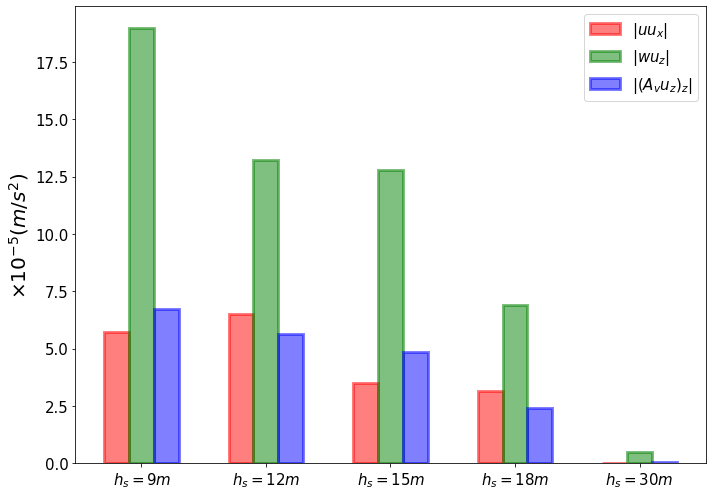

In [12]:
#labels = [r'$uu_x$', r'$wu_z$', r'$(A_v{u_z})_z$']
labels = [r'$h_s=9m$', r'$h_s=12m$', r'$h_s=15m$', r'$h_s=18m$', r'$h_s=30m$']


N = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars


fig2, ax = plt.subplots(figsize=(10,7))

ax.bar(N - width, np.abs(ADVh)*1e5, width, label=r'$|uu_x|$', facecolor='r', edgecolor='r', linewidth=3, alpha=.5)
ax.bar(N , np.abs(ADVv)*1e5, width, label=r'$|wu_z|$', facecolor='g', edgecolor='g', linewidth=3, alpha=.5)
ax.bar(N + width, np.abs(Vis)*1e5, width, label=r'$|(A_v{u_z})_z|$', facecolor='b', edgecolor='b', linewidth=3, alpha=.5)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel(r'$\times10^{-5}(m/s^2)$', fontsize=20)
#ax.set_title('Scores by group and gender')
ax.set_xticks(N)
ax.set_xticklabels(labels, fontsize=20)
ax.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
fig2.tight_layout()

In [13]:
fig_path = "/Users/weiyangbao/Documents/Results_Figs/Parameter/"
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

fig1.savefig(fig_path + '/Mom_dis_18m.png', dpi=200, bbox_inches='tight')
fig2.savefig(fig_path + '/Mom_mag.png', dpi=200, bbox_inches='tight')